# Homework 2

**The following notebook is meant to help you work through Problems 1 and 3 on Homework 2. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


In [106]:
# loading data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.patches as mpatches
from scipy.special import expit as sigmoid
from scipy.special import softmax
from scipy.special import logsumexp
from statistics import mode
from math import isclose


# data for Problem 1
t_obs, y_obs = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T
t_obs = np.split(t_obs, 10)
y_obs = np.split(y_obs.reshape(-1, 1), 10)

# data for Problem 3
data = pd.read_csv("data/hr.csv")
mapper = {
    "Dwarf": 0,
    "Giant": 1,
    "Supergiant": 2
}
data['Type'] = data['Type'].map(mapper)

X_stars = data[['Magnitude', 'Temperature']].values
y_stars = data['Type'].values

from T2_P1_TestCases import test_p1, test_p1_basis3_unstable_implementation
from T2_P3_TestCases import test_p3_softmax, test_p3_knn

import logging
logging.basicConfig(
            format='%(asctime)s %(levelname)-8s %(message)s',
            level=logging.INFO,
            datefmt='%Y-%m-%d %H:%M:%S')

logger = logging.getLogger()
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problem 1

## Problem 1 Subpart 1

In [2]:
def add_bias(T):
    """Adds a column of 1s to T, where T is a 2D array"""
    return np.hstack((np.ones(len(T)).reshape(-1,1), T))

def basis1(t):
    """Adds a column of 1s to t, where t is a 1D vector"""
    return np.stack([np.ones(len(t)), t], axis=1)

def basis2(t):
    """
    Transform t into basis [1, t, t^2]

    :param t: a 1D numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 3)
    """
    out = np.array([t**j for j in range(0,3)]).T
    assert out.shape == (len(t), 3)
    return out

def basis3(t):
    """
    Transform t into basis [1, t, t^2, t^3, t^4, t^5]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 6)
    """
    out = np.array([t**j for j in range(0,6)]).T
    assert out.shape == (len(t), 6)
    return out


def basis_close_to_truth(t):
    out = np.array([[1, i, 0.4*np.cos(1.1*i + 1)] for i in t])
    assert out.shape == (len(t),3)
    return out

In [6]:
# Testing basis functions
tmp = np.array([1,2,3,4])
print(tmp.shape)
basis_close_to_truth(tmp)

(4,)


array([[ 1.        ,  1.        , -0.20193844],
       [ 1.        ,  2.        , -0.39931791],
       [ 1.        ,  3.        , -0.16031967],
       [ 1.        ,  4.        ,  0.25387715]])

In [3]:
# taken from the Debugging ML colab
# TODO: ask how we parse the stable_llkhd function.
from scipy.special import logsumexp

sigmoid = lambda z: 1. / (1. + np.exp(-z))

def llkhd(x, y, w):
  return np.sum(y * np.log(sigmoid(w * x)) + (1 - y) * np.log(1 - sigmoid(w * x)))

def stable_llkhd(x, y, w):
  y_recoded = y.copy()
  y_recoded[y_recoded == 1] = -1
  y_recoded[y_recoded == 0] = 1

  # TODO: below line wasn't working. Why? This is what Weiwei had.
  # return -np.sum([logsumexp([0, arg]) for arg in y_recoded * (w * x)]) # original
  return -np.sum([logsumexp([0, arg]) for arg in np.dot(y_recoded, np.dot(x, w).T)])

# print('log-likelihood:', stable_llkhd(x, y, w))

In [19]:
# TODO: debugging sigmoid and gradient function
a = np.array([[1,0], [2,0], [3,0]])
b = np.array([1,2])

print(a.shape)
print(b.shape)
sigmoid(np.dot(a,b)).shape

(3, 2)
(2,)


(3,)

In [4]:
class LogisticRegressor:
    def __init__(self, eta, runs):
        self.eta = eta
        self.runs = runs
        self.W = None

    # define the loss function and the gradient of the loss function
    def f(self, x,y):
        # TODO: generate the stable version with logsumexp
        # return stable_llkhd(x,y, self.W) # https://hackmd.io/@onefishy/Syok9suhj
        # return llkhd(x, y, self.W)
        return -np.sum(y * np.log(sigmoid(np.dot(x, self.W))) + (1 - y) * np.log(1 - sigmoid(np.dot(x, self.W))))

    # TODO: how to compte the gradient?? I need help reviewing this. 
    # See answer in this edstem post #235 https://edstem.org/us/courses/34885/discussion/2585246
    def grad_f(self, x, y):
        """Gradient for logistic regression"""
        # do the average of the gradient to help speed things up, scaling by the number of datapoints in X
        logging.debug(f"x: {x.shape}, y: {y.shape}, w: {self.W.shape}")
        assert y.shape == (len(x), 1)
        assert self.W.shape == (x.shape[1], 1), f"expect shape {(x.shape[1], 1)} but have shape {self.W.shape}" 
        assert (y - sigmoid(np.dot(x,self.W))).shape == y.shape
        assert (1/len(x)*np.dot(x.T, (y - sigmoid(np.dot(x,self.W))))).shape == (x.shape[1], 1), f"expect gradient shape {(x.shape[1], 1)} but have shape {(1/len(x)*np.sum(y - sigmoid(np.dot(self.W.T, x)))*x).shape}"
        # TODO: do I want a negative or positive here? How do I know which?? "we want to minimize the negative log-likelihood"
        return -1/len(x)*np.dot(x.T, (y - sigmoid(np.dot(x,self.W))))

    def fit(self, x, y, w_init):
        """
        Optimize the weights W to minimize the negative log-likelihood by using gradient descent

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :param y: a 2D numpy array of output values. Shape is (n x 1)
        :param w_init: a 2D numpy array that initializes the weights. Shape is (d x 1), equivalent to the number of cols in the feature vector
        :return: None
        """
        # Keep this for the autograder
        self.W = w_init
        # TODO: can't get my loss function to work
        loss = [self.f(x, y)]
        for i in range(self.runs):
            # update the weights
            self.W = self.W - self.eta * self.grad_f(x, y)
            loss.append(self.f(x, y))
        return loss

    def predict(self, x):
        """
        Predict classification probability of transformed input x
        
        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :return: a 2D numpy array of predicted probabilities given current weights. Shape should be (n x 1)
        """
        # TODO: check this, but I think we do want to apply the sigmoid function to convert to probability
        assert self.W.shape == (x.shape[1], 1)
        y_pred = sigmoid(np.dot(x, self.W))
        assert y_pred.shape == (len(x), 1)
        assert all(y_pred <= 1) and all(y_pred >=0), f"Probabilities should be between 0 and 1 but these were the values you had: {y_pred}"
        return y_pred


In [105]:
# TODO: delete. Testing different types of multiplication
print(a)
print(b)
print(a * 2*b)
print(np.matmul(a, b))
print(np.dot(a, b))

[[1 0]
 [2 0]
 [3 0]]
[1 2]
[[2 0]
 [4 0]
 [6 0]]
[1 2 3]
[1 2 3]


[[0.47662057]
 [0.10811676]]


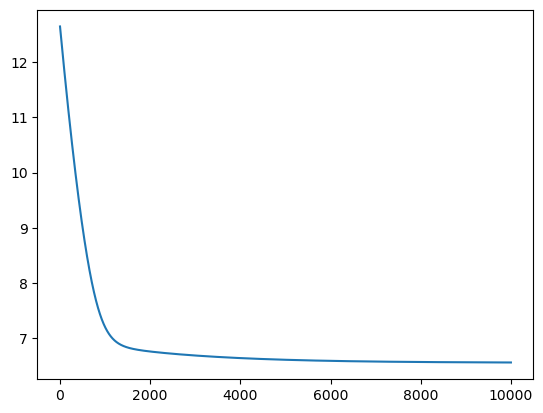

In [109]:
# Regenerating the test results
x_debug = np.array([-8, -3, -2, -1, 0, 1, 2, 3, 4, 5])
x_debug = basis1(x_debug)
y_debug = np.array([1, 0, 1, 0, 0, 0, 1, 1, 1, 1]).reshape(-1, 1)
logistic_test = LogisticRegressor(eta=0.001, runs=10000)
loss = logistic_test.fit(x_debug, y_debug, np.ones((x_debug.shape[1], 1)))
print(logistic_test.W)
plt.plot(np.arange(10000 + 1), loss)
plt.show()

In [5]:
test_p1(LogisticRegressor, basis1, basis2, basis3)

/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_42010/3931665827.py:12: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sigmoid(np.dot(x, self.W))) + (1 - y) * np.log(1 - sigmoid(np.dot(x, self.W))))
/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_42010/3931665827.py:12: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y * np.log(sigmoid(np.dot(x, self.W))) + (1 - y) * np.log(1 - sigmoid(np.dot(x, self.W))))
/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_42010/3974695717.py:5: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda z: 1. / (1. + np.exp(-z))


Your test case results are, for basis 1, 2, and 3 respectively: Pass Pass Fail


In [6]:
test_p1_basis3_unstable_implementation(LogisticRegressor, basis3)

/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_42010/3974695717.py:5: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda z: 1. / (1. + np.exp(-z))
/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_42010/3931665827.py:12: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sigmoid(np.dot(x, self.W))) + (1 - y) * np.log(1 - sigmoid(np.dot(x, self.W))))
/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_42010/3931665827.py:12: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y * np.log(sigmoid(np.dot(x, self.W))) + (1 - y) * np.log(1 - sigmoid(np.dot(x, self.W))))


Actual - Model: [[ 0.00669999]
 [-0.01357118]
 [ 0.02980618]
 [-0.11266412]
 [ 0.00487577]
 [ 0.01544255]]
Your test case results for basis 3 is: Fail


In [23]:
# TODO: Adding code for Problem 1.1
# making the logistic regression models for each basis
eta = 0.001
n_iter = 10000

# basis1_models = []
# for x,y in zip(t_obs, y_obs):
#     curr_model = LogisticRegressor(eta, n_iter)
#     curr_model.fit(basis1(x), y, w_init=np.zeros((basis1(x).shape[1],1)))
#     basis1_models.append(curr_model)

def problem1_1_make_model_list(eta, runs, basis):
    basis_models = []
    for x,y in zip(t_obs, y_obs):
        curr_model = LogisticRegressor(eta, n_iter)
        curr_model.fit(basis(x), y, w_init=np.ones((basis(x).shape[1],1)))
        basis_models.append(curr_model)
    return basis_models

basis1_models = problem1_1_make_model_list(eta, n_iter, basis1)
basis2_models = problem1_1_make_model_list(eta, n_iter, basis2)
basis3_models = problem1_1_make_model_list(eta, n_iter, basis3)
close_to_truth_models = problem1_1_make_model_list(eta, n_iter, basis_close_to_truth)

/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_34706/2321482285.py:5: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda z: 1. / (1. + np.exp(-z))


## Plotting Functions for Problem 1, Subpart 2

In [7]:
# Function to visualize prediction lines
# Takes as input last_x, last_y, [list of models], basis function, title
# last_x and last_y should specifically be the dataset that the last model
# in [list of models] was trained on
def visualize_prediction_lines(last_x, last_y, models, basis, title):
    # Plot setup
    green = mpatches.Patch(color='green', label='Ground truth model')
    black = mpatches.Patch(color='black', label='Mean of learned models')
    purple = mpatches.Patch(color='purple', label='Model learned from displayed dataset')
    plt.legend(handles=[green, black, purple], loc='lower right')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Observed')
    plt.axis([0, 6, -.1, 1.1]) # Plot ranges

    # Plot dataset that last model in models (models[-1]) was trained on
    cmap = c.ListedColormap(['r', 'b'])
    plt.scatter(last_x, last_y, c=last_y, cmap=cmap, linewidths=1, edgecolors='black')

    # Plot models
    X_pred = np.linspace(0, 6, 1000)
    X_pred_transformed = basis(X_pred)

    ## Ground truth model
    plt.plot(X_pred, np.cos(1.1*X_pred + 1) * 0.4 + 0.5, 'g', linewidth=5)

    ## Individual learned logistic regressor models
    Y_hats = []
    for i in range(len(models)):
        model = models[i]
        Y_hat = model.predict(X_pred_transformed)
        Y_hats.append(Y_hat)
        if i < len(models) - 1:
            plt.plot(X_pred, Y_hat, linewidth=.3)
        else:
            plt.plot(X_pred, Y_hat, 'purple', linewidth=3)

    # Mean / expectation of learned models over all datasets
    plt.plot(X_pred, np.mean(Y_hats, axis=0), 'k', linewidth=5)

    plt.savefig(title + '.png')
    plt.show()

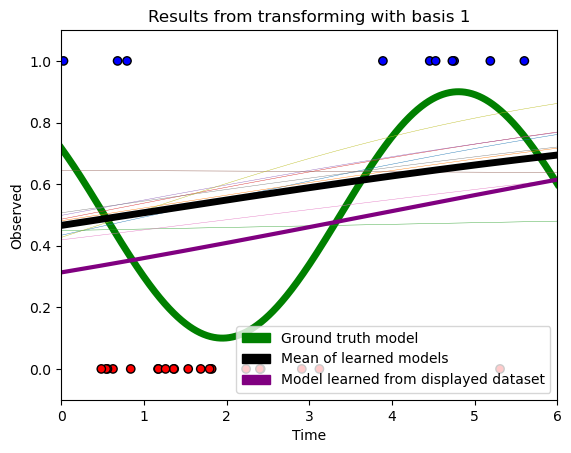

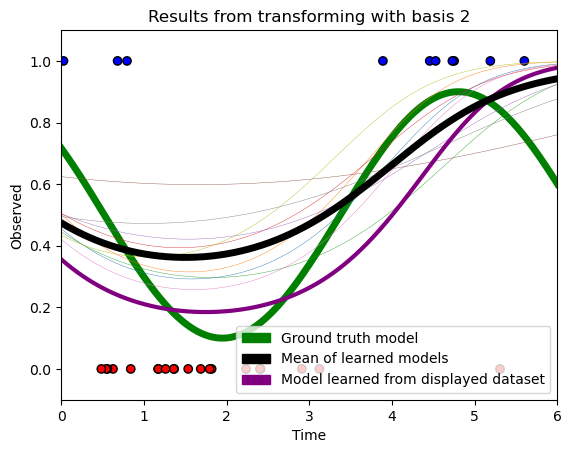

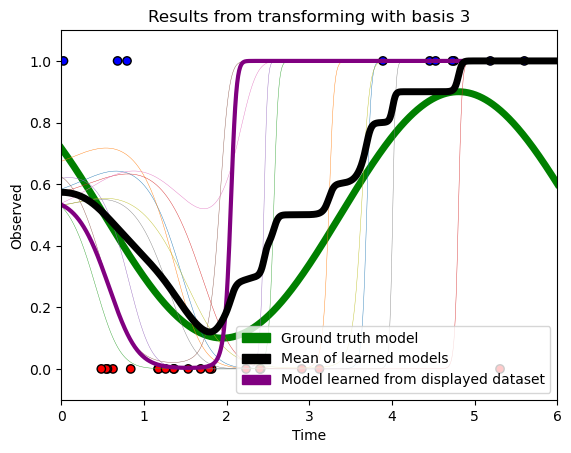

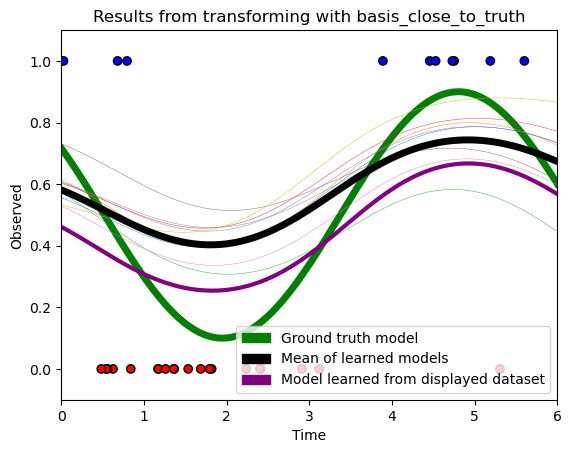

In [25]:
# TODO: Problem 1.2 code
# TODO: these don't look like what I expect. I expect the bases with higher degree to better match the ground truth model, but all of mine look terrible.
last_x = t_obs[-1]
last_y = y_obs[-1]
visualize_prediction_lines(last_x, last_y, models=basis1_models, basis=basis1, title="Results from transforming with basis 1")
visualize_prediction_lines(last_x, last_y, models=basis2_models, basis=basis2, title="Results from transforming with basis 2")
visualize_prediction_lines(last_x, last_y, models=basis3_models, basis=basis3, title="Results from transforming with basis 3")
visualize_prediction_lines(last_x, last_y, models=close_to_truth_models, basis=basis_close_to_truth, title="Results from transforming with basis_close_to_truth")

In [8]:
# You may find it helpful to modify this function for Problem 1, Subpart 4,
# but do not change the existing code--add your own variables
# Gwen note: I think that this is actually what I ended up doing for Problem 1, Subpart 3. I don't see how this would be useful for subpart 4.
def plot_results(basis, title, 
                 t_obs=t_obs, y_obs=y_obs, 
                 eta=0.001, runs = 10000):
    all_models = []
    for i in range(len(t_obs)):
        x, y = t_obs[i], y_obs[i]
        x_transformed = basis(x)
        model = LogisticRegressor(eta=eta, runs=runs)
        model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
        all_models.append(model)

    visualize_prediction_lines(x, y, all_models, basis, title)

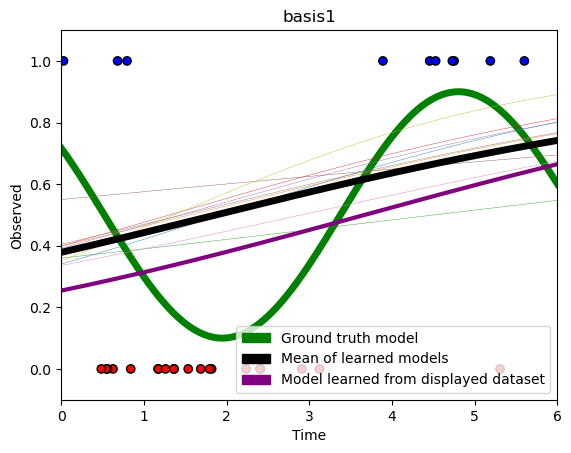

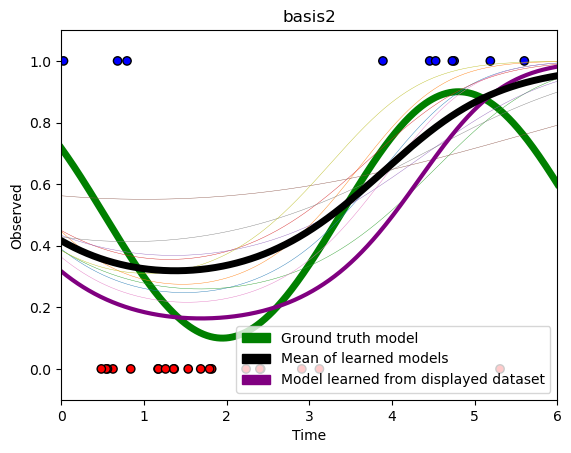

/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_34706/2190287427.py:12: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sigmoid(np.dot(x, self.W))) + (1 - y) * np.log(1 - sigmoid(np.dot(x, self.W))))
/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_34706/2190287427.py:12: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y * np.log(sigmoid(np.dot(x, self.W))) + (1 - y) * np.log(1 - sigmoid(np.dot(x, self.W))))
/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_34706/3974695717.py:5: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda z: 1. / (1. + np.exp(-z))
/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_34706/3974695717.py:5: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda z: 1. / (1. + np.exp(-z))


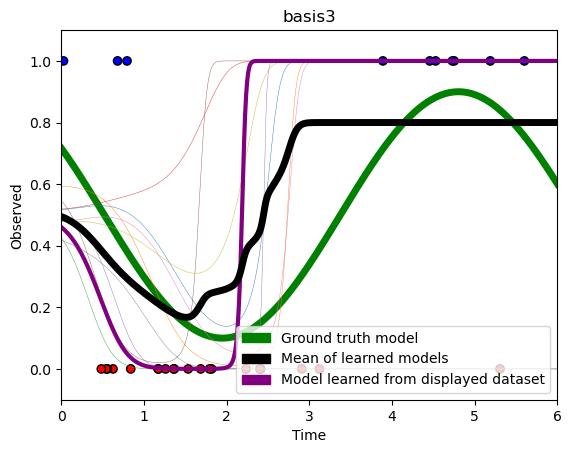

In [134]:
plot_results(basis1, 'basis1')
plot_results(basis2, 'basis2')
plot_results(basis3, 'basis3')

## Problem 1.3 (how does increasing the mini-batch size change bias and variance?)

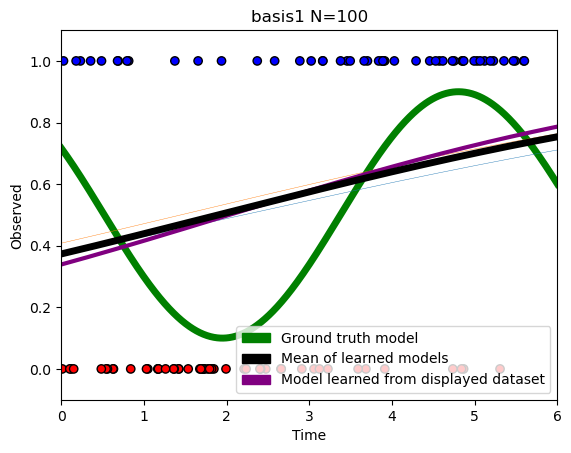

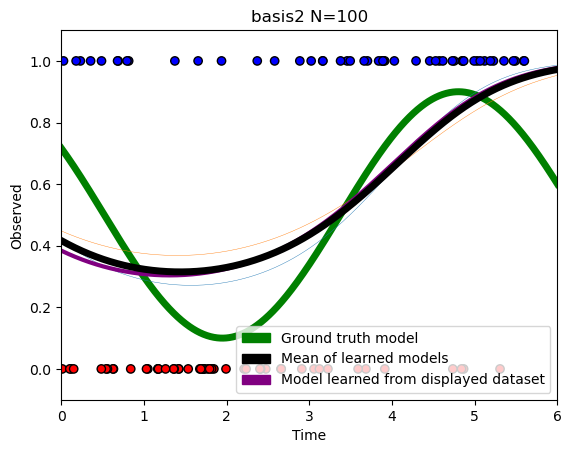

/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_34706/2190287427.py:12: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(sigmoid(np.dot(x, self.W))) + (1 - y) * np.log(1 - sigmoid(np.dot(x, self.W))))
/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_34706/2190287427.py:12: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y * np.log(sigmoid(np.dot(x, self.W))) + (1 - y) * np.log(1 - sigmoid(np.dot(x, self.W))))
/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_34706/3974695717.py:5: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda z: 1. / (1. + np.exp(-z))


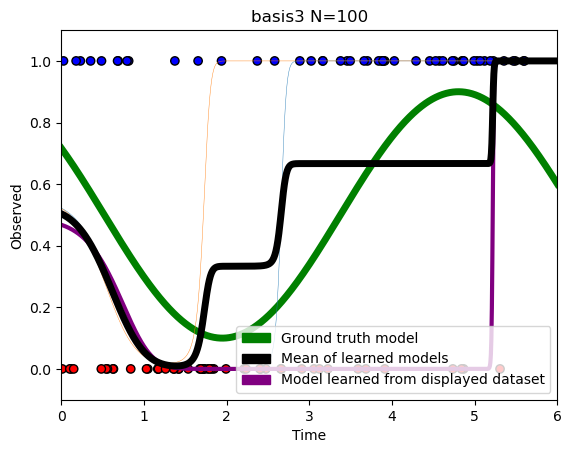

In [137]:
# 1. Make dsets of N=100 instead of N=30
N = 100
t_obs_100, y_obs_100 = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T
t_obs_100 = np.split(t_obs_100, 3)
y_obs_100 = np.split(y_obs_100.reshape(-1, 1), 3)

# 3. Make plots (function transforms data, fits models, and plots against ground truth)              
plot_results(basis1, f'basis1 N={N}', t_obs=t_obs_100, y_obs=y_obs_100, 
                 eta=0.001, runs = 10000)
plot_results(basis2, f'basis2 N={N}', t_obs=t_obs_100, y_obs=y_obs_100,
                 eta=0.001, runs = 10000)
plot_results(basis3, f'basis3 N={N}', t_obs=t_obs_100, y_obs=y_obs_100, 
                 eta=0.001, runs = 10000)

In [ ]:
# 1. Make dsets of N=50 instead of N=30
N = 100
t_obs_50, y_obs_50 = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T
t_obs_50 = np.split(t_obs_50, 6)
y_obs_50 = np.split(y_obs_50.reshape(-1, 1), 6)

# 3. Make plots (function transforms data, fits models, and plots against ground truth)              
plot_results(basis1, f'basis1 N={N}', t_obs=t_obs_50, y_obs=y_obs_50, 
                 eta=0.001, runs = 10000)
plot_results(basis2, f'basis2 N={N}', t_obs=t_obs_50, y_obs=y_obs_50,
                 eta=0.001, runs = 10000)
plot_results(basis3, f'basis3 N={N}', t_obs=t_obs_50, y_obs=y_obs_50, 
                 eta=0.001, runs = 10000)

## Problem 1.4

In [27]:
# Truth for probability of observation:
t = np.array([0.1, 3.2])
0.4*np.cos(1.1*t + 1) + 0.5

array([0.67786461, 0.42351826])

In [138]:
t = np.array([0.1, 3.2])
obs_probs = basis3_models[0].predict(basis3(t))
print(f"predicted obs probs for early and late timepoint: {obs_probs}")

early_t = np.array([0.1])
late_t = np.array([3.2])
var_early_timepoint = np.var([model.predict(basis3(early_t)) for model in basis3_models])
var_late_timepoint = np.var([model.predict(basis3(late_t)) for model in basis3_models])
print(f"var_early_timepoint: {round(var_early_timepoint, 3)}. var_late_timepoint: {round(var_late_timepoint,3)}")
# TODO: Sanity check failed. We see that the probability of seeing the planet at time 0.1 is much larger(?) than that of time 3.2 for the first model.... isn't this backwards?

predicted obs probs for early and late timepoint: [[5.93919228e-01]
 [5.69806365e-05]]
var_early_timepoint: 0.003. var_late_timepoint: 0.228


# Problem 3

In [148]:
# TODO: delete. Testing wit the eye function
np.eye(5)[[0,1,1,2,2]]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [24]:
np.argmax(a, axis=1)

array([0, 0, 0])

In [38]:
e = np.arange(0,20,1).reshape(4,-1)
print(e)
np.argmax(e, axis=1)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]


array([4, 4, 4, 4])

In [132]:
# Hyperparameters
N_ITER = 200000
ETA = 0.001

class SoftmaxRegression:
    def __init__(self, eta, lam):
        self.eta = eta
        self.lam = lam
        self.W = None

    def loss(self, X, y, l2_regularize=True):
        # TODO: CHECK. implement stable version with logsumexp, check that this implementation is correct
        # return the negative log-likelihood of the data (calculated in HW2 2.2)
        # - sum over n * sum over k of (y_{ik}*log(softmax(w^T x_i)))
        assert y.shape == (len(X),), f"y wasn't the expected shape of (n,): {y.shape}"
        # convert y to a matrix size (n,K)
        # https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-one-hot-encoded-array-in-numpy
        K = len(self.W)
        Y = np.eye(K)[y.reshape(-1)]
        assert Y.shape == (len(X), len(self.W)), f"Y matrix wasn't the expected shape of (n,K): {Y.shape}"
        loss = - np.trace( np.dot(Y, np.log(np.dot(self.W, X.T))) )
        if l2_regularize:
            loss += (self.lam/2) * np.linalg.norm(self.W)**2
        return loss        


    def grad_f(self, X, y, l2_regularize=True):
        """
        Gradient for multi-class logistic regression. 
        Calculated in HW 2 2.4
        Returns:
            grad: K x d numpy array
        """
        logging.debug(f"X: {X.shape}, y: {y.shape}, W: {self.W.shape}")
        assert y.shape == (len(X), )
        assert np.dot(X, self.W.T).shape == (len(X), len(self.W)), "Dimensions of X and self.W aren't correct"
        # convert y to a matrix size (n,K)
        # https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-one-hot-encoded-array-in-numpy
        K = len(self.W)
        Y = np.eye(K)[y.reshape(-1)]
        assert Y.shape == (len(X), K)

        logging.debug("softmax(np.dot(self.W, X.T), axis=0): ", softmax(np.dot(self.W, X.T), axis=0))
        assert softmax(np.dot(self.W, X.T), axis=0).shape == (K, len(X))
        assert softmax(np.dot(self.W, X.T), axis=0).sum(axis=0).shape == (len(X),)
        # assert all([isclose(i, 1, abs_tol=1e-8) for i in softmax(np.dot(self.W, X.T), axis=0).sum(axis=0)]), f"The sum across softmax should sum to 1: {[i==1 for i in softmax(np.dot(self.W, X.T), axis=0).sum(axis=0)]} \n {softmax(np.dot(self.W, X.T), axis=0).shape} \n{softmax(np.dot(self.W, X.T), axis=0)}"
        # TODO: should this be negative? Double check this formula...
        grad = np.dot(softmax(np.dot(self.W, X.T), axis=0) - Y.T, X)
        assert grad.shape == self.W.shape, f"grad.shape = {grad.shape} but should be {self.W.shape}"
        if l2_regularize is True: # TODO: check. Is this the way to do this?
                grad += self.lam * self.W
        assert grad.shape == self.W.shape, f"grad.shape = {grad.shape} but should be {self.W.shape}"
        return grad
        

    def fit(self, X, y, runs=N_ITER):
        """
        Fit the weights W of softmax regression using gradient descent with L2 regularization
        in the form (lambda/2) * norm(w)^2
        Use the results from Problem 2 to find an expression for the gradient
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """
        # TODO: should I add the bias column to X here or not?
        X = add_bias(X)
        # Initializing the weights (do not change!) 
        # The number of classes is 1 + (the highest numbered class)
        num_classes = 1 + y.max()
        num_features = X.shape[1]
        self.W = np.ones((num_classes, num_features))
        loss = []
        for i in range(N_ITER):
            self.W = self.W - self.eta * self.grad_f(X, y, self.W)
            loss.append(self.loss(X, y))
        return loss
    

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        # TODO
        # report the argmax for each data point (go from n x K --> n x 1)
        y_pred = np.argmax(self.predict_proba(X_pred), axis = 1)
        assert y_pred.shape == (X_pred.shape[0],), f"The prediction should have length n={X_pred.shape[0]} (the number of test pointsa) but has shape {y_pred.shape}"
        return y_pred

    
    def predict_proba(self, X_pred):
        """    
        Predict classification probabilities of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Dwarf=index 0, Giant=index 1, Supergiant=index 2).
                 Shape should be (n x 3)
        """
        # TODO: check: should I add the bias here or not?
        X_pred = add_bias(X_pred)
        assert self.W.shape[1] == X_pred.shape[1], f"self.W.shape[1] != X_pred.shape[1]: shapes are W  {self.W.shape} vs X_pred {X_pred.shape}"
        y_pred = softmax(np.dot(X_pred,self.W.T))
        assert y_pred.shape == (X_pred.shape[0], len(self.W)), f"The output from softmax should have shape {(X_pred.shape[0], len(self.W))} but has shape {y_pred.shape}"
        assert all(y_pred.reshape(-1) <= 1) and all(y_pred.reshape(-1) >=0), f"Probabilities should be between 0 and 1 but these were the values you had: {y_pred}"
        return y_pred

In [133]:
# TODO: delete
from math import isclose

print(a)
print(a.shape)
print("softmax: \n", softmax(a, axis=0))
print(softmax(a, axis=0).sum(axis=0))
print([isclose(i, 1, abs_tol=1e-8) for i in softmax(a, axis=0).sum(axis=0)])

[[1 0]
 [2 0]
 [3 0]]
(3, 2)
softmax: 
 [[0.09003057 0.33333333]
 [0.24472847 0.33333333]
 [0.66524096 0.33333333]]
[1. 1.]
[True, True]


In [172]:
class KNNClassifier:
    def __init__(self, k):
        self.X = None
        self.y = None
        self.K = k
        
    def fit(self, X, y):
        """
        In KNN, "fitting" can be as simple as storing the data, so this has been written for you.
        If you'd like to add some preprocessing here without changing the inputs, feel free,
        but this is completely optional.
        # Note: I don't think we need to add a bias term here because we aren't fitting a parametric model
        """
        self.X = X
        self.y = y

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        # TODO: Is there a better way to implement?
        # for each star in X_pred, assign label according to the mode class of its K nearest neighbors in self.X
        preds = []
        for curr_star in X_pred:
            curr_dists = [self.distance(star, curr_star) for star in self.X]
            # get indexes corresponding to the closest k stars in our dataset
            k_nearest = np.argpartition(curr_dists, self.K)[:self.K]
            # class labels of the closest k stars
            labels = self.y[k_nearest]
            # assign current star the most common class of its neighbors (e.g. 2 Dwarfs and 1 Giant ==> Dwarf)
            pred_class = mode(labels.tolist())
            preds.append(pred_class)
        preds = np.array(preds)
        return preds
    
    def distance(self, star1, star2):
        return (star1[0] - star2[0])**2/9 + (star1[1] - star2[1])**2

In [173]:
def phi(X):
    """
    Transform [x_1, x_2] into basis [ln(x_1 + 10), x_2^2]

    :param t: a 2D numpy array of values to transform. Shape is (n x 2)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 2)
    """
    transformed = np.array([np.log(X[:,0] + 10), X[:,1]**2]).T
    assert transformed.shape == (len(X), 2)
    return transformed

# Testing the phi function
d = np.array([[1,1], [2,2], [3,3]])
print(d)
phi(d)

[[1 1]
 [2 2]
 [3 3]]


array([[2.39789527, 1.        ],
       [2.48490665, 4.        ],
       [2.56494936, 9.        ]])

## Plotting Function for Problem 3, Subpart 1

In [136]:
# Visualize the decision boundary that a model produces
def visualize_boundary(model, X, y, title, basis=None, width=2):
    # Create a grid of points
    x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
    y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    # Flatten the grid so the values match spec for self.predict
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    X_pred = np.vstack((xx_flat, yy_flat)).T
    
    if basis is not None:
        X_pred = basis(X_pred)

    # Get the class predictions
    Y_hat = model.predict(X_pred)
    Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

    # Visualize them.
    cmap = c.ListedColormap(['r', 'b', 'g'])
    plt.figure()
    plt.title(title)
    plt.xlabel('Magnitude')
    plt.ylabel('Temperature')
    plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, linewidths=1,
                edgecolors='black')

    # Adding a legend and a title
    red = mpatches.Patch(color='red', label='Dwarf')
    blue = mpatches.Patch(color='blue', label='Giant')
    green = mpatches.Patch(color='green', label='Supergiant')
    plt.legend(handles=[red, blue, green])

    # Saving the image to a file, and showing it as well
    plt.savefig(title + '.png')
    plt.show()

## Problem 3, Subpart 1

/var/folders/h5/9x874mtn1z1031f_h6w7df7r0000gp/T/ipykernel_42010/1980626889.py:21: RuntimeWarning: invalid value encountered in log
  loss = - np.trace( np.dot(Y, np.log(np.dot(self.W, X.T))) )


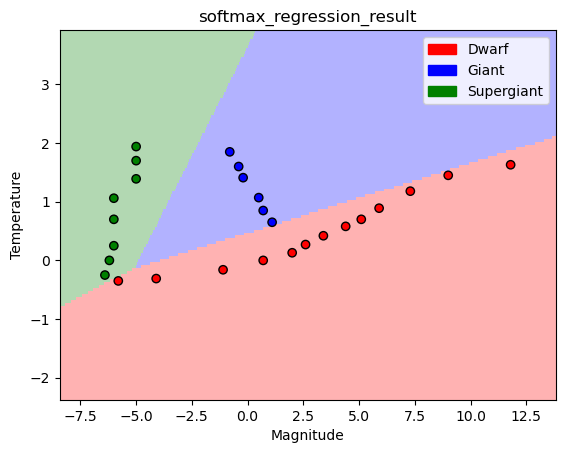

In [159]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
softmax_model = SoftmaxRegression(eta=0.001, lam=0.001)
softmax_model.fit(X_stars, y_stars)
loss_soft = visualize_boundary(model=softmax_model,
                   X=X_stars,
                   y=y_stars,
                   title='softmax_regression_result',
                   basis=None)

In [160]:
print("weights: \n", softmax_model.W) # when have the positive of the l(w) given in HW 2 2.4
# checking if the gradient is close to zero, and it seems to be...
print("gradient: \n", softmax_model.grad_f(add_bias(X_stars), y_stars))

weights: 
 [[ 13.35177875   3.90454253 -16.87089552]
 [  1.63149393   0.93664259   8.06620926]
 [-11.98327268  -1.84118512  11.80468626]]
gradient: 
 [[-0.00587718 -0.00095939  0.01666803]
 [ 0.00302701  0.00179812 -0.00622502]
 [ 0.00585017  0.00216128 -0.00744301]]


In [161]:
# ground truth minus my weights
np.array([[ 12.15018853,   3.47210863, -15.42831204],
            [  1.39297954,   0.77669976,   7.24823083],
            [-11.08697852,  -1.79261884,  10.63627077]]) - softmax_model.W

array([[-1.20159022, -0.4324339 ,  1.44258348],
       [-0.23851439, -0.15994283, -0.81797843],
       [ 0.89629416,  0.04856628, -1.16841549]])

In [ ]:
logging.info("building the multiclass logistic regression models...")
basis_model = SoftmaxRegression(eta=0.001, lam=0.001)
loss_basis = basis_model.fit(phi(X_stars), y_stars)
# checking if the gradient is close to zero, and it seems to be...
basis_model.grad_f(add_bias(phi(X_stars)), y_stars)

In [150]:
# checking if the gradient is close to zero, and it seems to be...
basis_model.grad_f(add_bias(phi(X_stars)), y_stars)

array([[ 0.00537656, -0.00264801,  0.00124334],
       [ 0.00828162, -0.00485446,  0.00274001],
       [-0.01065818,  0.01050247, -0.00098335]])

In [145]:
# from the ground-truth test file
basis_weights = np.array([[-8.92386417,  7.42723212, -0.98134742],
       [-5.27857827,  4.90932063,  0.55637391],
       [16.65863199, -9.8803632 ,  2.88116307]])
# ground truth minus my weights
basis_weights - basis_model.W

array([[ 0.63871151, -0.77227407, -0.06259927],
       [ 0.56350502, -0.73957853, -0.06839663],
       [-1.74602699,  0.96804215, -0.41281455]])

In [174]:
# test your models by passing your fitted models into the functions below
# softmax_model is an instance of class SoftmaxRegression fitted to data X_stars, y_stars
# basis_model is an instance of class SoftmaxRegression fitted to data phi(X_stars), y_stars
# knn1_model is an instance of class KNNClassifier with parameter k=1
# knn5_model is an instance of class KNNClassifier with parameter k=5

logging.info("building the multiclass logistic regression model with no basis...")
softmax_model = SoftmaxRegression(eta=0.001, lam=0.001)
softmax_model.fit(X_stars, y_stars)
logging.info("building the multiclass logistic regression models...")
basis_model = SoftmaxRegression(eta=0.001, lam=0.001)
basis_model.fit(phi(X_stars), y_stars)
logging.info("testing the multiclass logistic regression models...")
test_p3_softmax(softmax_model, basis_model)

logging.info("building the KNN models...")
knn1_model = KNNClassifier(1)
knn1_model.fit(X_stars, y_stars)
knn5_model = KNNClassifier(5)
knn5_model.fit(X_stars, y_stars)
logging.info("testing the KNN models...")
test_p3_knn(knn1_model, knn5_model)

2023-02-23 16:28:18 INFO     building the KNN models...
2023-02-23 16:28:18 INFO     testing the KNN models...


Passed KNN tests


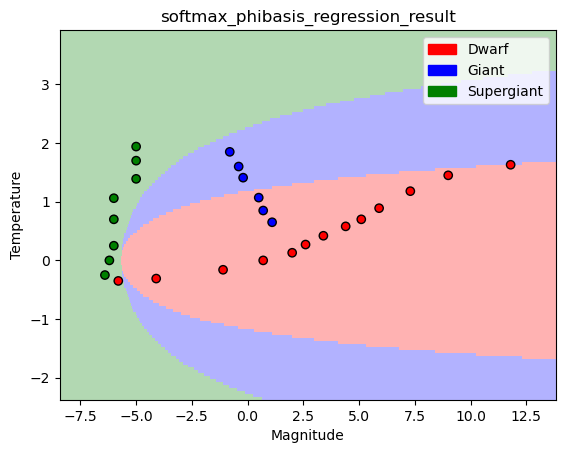

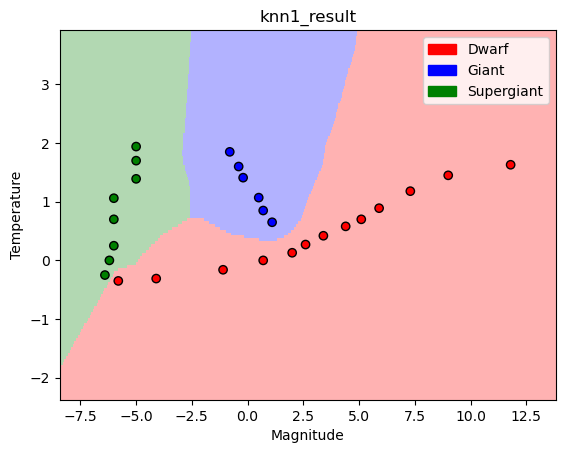

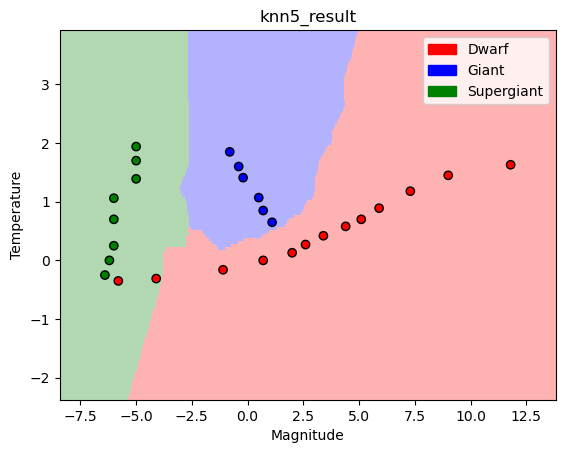

In [175]:
# visualize each of the four models in the chunk above
## Multiclass logistic
loss_soft = visualize_boundary(model=softmax_model,
                   X=X_stars,
                   y=y_stars,
                   title='softmax_regression_result',
                   basis=None)

visualize_boundary(model=basis_model,
                   X=X_stars,
                   y=y_stars,
                   title='softmax_phibasis_regression_result',
                   basis=phi)
## KNN                   
visualize_boundary(model=knn1_model,
                   X=X_stars,
                   y=y_stars,
                   title='knn1_result',
                   basis=None)
visualize_boundary(model=knn5_model,
                   X=X_stars,
                   y=y_stars,
                   title='knn5_result',
                   basis=None)

## Problem 3.2

In [205]:
new_star = np.array([[3., -2.]])
logging.debug(new_star.shape)

# make predictions
print(f"softmax_model: {softmax_model.predict(new_star).item()} \n{softmax_model.predict_proba(new_star)}")
print(f"basis_model: {basis_model.predict(phi(new_star)).item()} \n{basis_model.predict_proba(phi(new_star))}")
print(f"knn1_model: {knn1_model.predict(new_star).item()}")
print(f"knn5_model: {knn5_model.predict(new_star).item()}")

assert isclose(basis_model.predict(phi(new_star)), 1, abs_tol = 1e-8)



softmax_model: 0 
[[1.00000000e+00 2.41559031e-31 4.01624006e-44]]
basis_model: 1 
[[3.37968750e-02 9.65607666e-01 5.95459207e-04]]
knn1_model: 0
knn5_model: 0


# Problem 4

In [55]:
# "typical" female patient
drug = sigmoid(0.2 + 0.8 - 0.012*50 + 0.001*168 - 0.007*140)
nodrug = sigmoid(0.2 - 0.012*50 + 0.001*168 - 0.007*140)
print(round(drug,3), round(nodrug, 3), round(drug-nodrug, 3))

0.398 0.229 0.169
